In [1]:
# standard
import numpy as np
import pandas as pd
import polars as pl
from sklearn.model_selection import train_test_split
import dask.dataframe as dd

# Import necessary libraries
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn.init as init
import matplotlib.pyplot as plt

from ignite.engine import create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss
from ignite.handlers import FastaiLRFinder

# generator1 = torch.Generator().manual_seed(42)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Supported Device: ", DEVICE)

# Decide random state
torch.manual_seed(42)
torch.set_default_dtype(torch.float32) #this is a bug, if using ADAM optimizer need to explicit in all operations. Can't just set default to float64
DTYPE = torch.float64

Supported Device:  cuda


In [2]:
# Define ResNet architecture without Batch Normalization
class ResidualBlock(nn.Module):
    def __init__(self, in_features, out_features):
        super(ResidualBlock, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(in_features, out_features, dtype=DTYPE),
            nn.ReLU(inplace=True).double(),
            nn.Linear(out_features, out_features, dtype=DTYPE),
            nn.ReLU(inplace=True).double(),
            nn.Linear(out_features, out_features, dtype=DTYPE),
        )
        if (in_features != out_features):
            self.fc = nn.Linear(in_features, out_features, dtype=DTYPE)
        else:
            self.fc = nn.Identity(dtype=DTYPE)
    
    def forward(self, x):
        return self.fc(x) + self.layer(x)

class ResNet(nn.Module):
    def __init__(self, in_features, out_features, hidden_features, num_blocks):
        super(ResNet, self).__init__()
        
        layers = [ResidualBlock(in_features, hidden_features)]
        layers += [ResidualBlock(hidden_features, hidden_features) for _ in range(num_blocks-2)]
        layers.append(ResidualBlock(hidden_features, out_features))

        self.network = nn.Sequential(*layers)
        self.fc = nn.Linear(out_features, out_features, dtype=DTYPE)
    
    def forward(self, x):
        out = self.network(x)
        return self.fc(out)
# He initialization function
def weights_init(m):
    if isinstance(m, nn.Linear):
        init.kaiming_uniform_(m.weight, nonlinearity='relu')  # He initialization
        if m.bias is not None:
            init.zeros_(m.bias)
            
def r2_score_custom(y_pred:torch.Tensor, y_true:torch.Tensor) -> float:
    
    ss_res = torch.sum((y_true - y_pred) ** 2)
    ss_tot = torch.sum((y_true - torch.mean(y_true)) ** 2)
    
    r2 = 1 - ss_res / ss_tot
    
    return r2.item()


In [3]:
%%time
# Import each file
# temporarily set n_rows for saving time
n_rows = 100000
folder = 'leap-atmospheric-physics-ai-climsim'
df_train = pl.read_csv('../input/'+folder+'/train.csv', n_rows=n_rows).to_pandas()
df_sub = pl.read_csv('../input/'+folder+'/sample_submission.csv', n_rows=2).to_pandas()

CPU times: user 9.77 s, sys: 3.19 s, total: 13 s
Wall time: 7.44 s


In [4]:
torch.manual_seed(42)
weights = df_sub.iloc[0, 1:].values.astype(np.float64)
weights = torch.tensor(weights, dtype=DTYPE)

# Prepare data for training
x_train = torch.tensor(1 * df_train.iloc[:, 1:557].values, dtype=DTYPE)
y_train = torch.tensor(1 * df_train.iloc[:, 557:].values, dtype=DTYPE)
y_train = y_train * weights

# Create a dataset and shuffle it
dataset = TensorDataset(x_train, y_train)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

y_t = y_train[train_dataset.indices, :].to(DEVICE, dtype = DTYPE)
y_v = y_train[val_dataset.indices, :].to(DEVICE, dtype = DTYPE)

SS_res_train = torch.sum((y_t - y_t.mean())**2)
SS_res_val = torch.sum((y_v - y_v.mean())**2)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=5000, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=5000, shuffle=True)

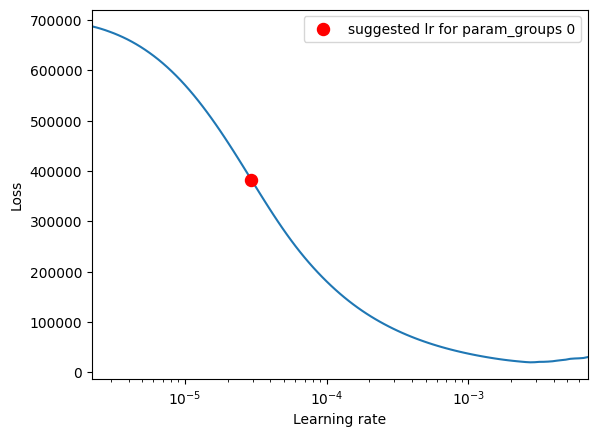

Suggested LR 2.942727176209282e-05


In [5]:
torch.manual_seed(42)

# Model parameters
input_dim = x_train.shape[1]
output_dim = y_train.shape[1]
hidden_dim = np.int64(np.mean([input_dim, output_dim]).round()) #hidden layers is the mean of the number of inputs and outputs
num_res_blocks = 7

# Create ResNet model
model = ResNet(input_dim, output_dim, hidden_dim, num_res_blocks)
model = model.to(DEVICE, dtype = DTYPE)
criterion = nn.MSELoss().to(DEVICE, dtype = DTYPE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)

trainer = create_supervised_trainer(model, optimizer, criterion, device=DEVICE)

lr_finder = FastaiLRFinder()

# To restore the model's and optimizer's states after running the LR Finder
to_save = {"model": model, "optimizer": optimizer}

with lr_finder.attach(trainer, to_save, end_lr=1e-01) as trainer_with_lr_finder:
    trainer_with_lr_finder.run(train_loader, max_epochs=10)

lr_finder.plot()

print("Suggested LR", lr_finder.lr_suggestion())

In [6]:
torch.manual_seed(42)

# Model parameters
input_dim = x_train.shape[1]
output_dim = y_train.shape[1]
hidden_dim = np.int64(np.mean([input_dim, output_dim]).round()) #hidden layers is the mean of the number of inputs and outputs
num_res_blocks = 7

# Create ResNet model
model = ResNet(input_dim, output_dim, hidden_dim, num_res_blocks)
model = model.to(DEVICE, dtype = DTYPE)

# Apply the He weight initialization (does not work well)
# model.apply(weights_init)

num_epochs = 200

# Training settings
criterion = nn.MSELoss(reduction = "mean").to(DEVICE, dtype = DTYPE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
lr_finder.apply_suggested_lr(optimizer)

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_in, batch_out in train_loader:
        
        batch_in = batch_in.to(DEVICE, dtype = DTYPE)
        batch_out = batch_out.to(DEVICE, dtype = DTYPE)

        optimizer.zero_grad()
        predictions = model(batch_in)
        
        loss = criterion(predictions, batch_out)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_in, batch_out in val_loader:
            batch_in = batch_in.to(DEVICE, dtype = torch.float64)
            batch_out = batch_out.to(DEVICE, dtype = torch.float64)

            predictions = model(batch_in)
            loss = criterion(predictions, batch_out)
            val_loss += loss.item()
#     scheduler.step()
    if (epoch + 1) % 10 == 0:
        Rsq_train = (train_loss * train_loader.batch_size * output_dim) / SS_res_train; Rsq_train = 1 - Rsq_train
        Rsq_test = (val_loss * val_loader.batch_size * output_dim) / SS_res_val; Rsq_test = 1 - Rsq_test
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}')
        print(f'Epoch [{epoch+1}/{num_epochs}], Train $R^2$: {Rsq_train:.4f}, Val $R^2$: {Rsq_test:.4f}')

Epoch [10/200], Train Loss: 17.4891, Val Loss: 16.7563
Epoch [10/200], Train $R^2$: -19.6219, Val $R^2$: -19.1577
Epoch [20/200], Train Loss: 14.8695, Val Loss: 14.5834
Epoch [20/200], Train $R^2$: -16.5331, Val $R^2$: -16.5437
Epoch [30/200], Train Loss: 12.8634, Val Loss: 12.5975
Epoch [30/200], Train $R^2$: -14.1676, Val $R^2$: -14.1547
Epoch [40/200], Train Loss: 10.8865, Val Loss: 10.6488
Epoch [40/200], Train $R^2$: -11.8366, Val $R^2$: -11.8104
Epoch [50/200], Train Loss: 9.0730, Val Loss: 8.8733
Epoch [50/200], Train $R^2$: -9.6982, Val $R^2$: -9.6745
Epoch [60/200], Train Loss: 7.5180, Val Loss: 7.3607
Epoch [60/200], Train $R^2$: -7.8647, Val $R^2$: -7.8548
Epoch [70/200], Train Loss: 6.2655, Val Loss: 6.1339
Epoch [70/200], Train $R^2$: -6.3879, Val $R^2$: -6.3791
Epoch [80/200], Train Loss: 5.2846, Val Loss: 5.1767
Epoch [80/200], Train $R^2$: -5.2312, Val $R^2$: -5.2275
Epoch [90/200], Train Loss: 4.5326, Val Loss: 4.4482
Epoch [90/200], Train $R^2$: -4.3445, Val $R^2$: -4

In [7]:
model.eval()
val_loss = 0
with torch.no_grad():
    for batch_in, batch_out in val_loader:
        batch_in = batch_in.to(DEVICE, dtype = torch.float64)
        batch_out = batch_out.to(DEVICE, dtype = torch.float64)

        predictions = model(batch_in)
        loss = criterion(predictions, batch_out)
        val_loss += loss.item()
    Rsq_test = (val_loss * val_loader.batch_size * output_dim) / SS_res_val; Rsq_test = 1 - Rsq_test
    print(f'Val $R^2$: {Rsq_test:.4f}')

Val $R^2$: -1.3328


In [8]:
x_v = x_train[val_dataset.indices, :].to(DEVICE, dtype = DTYPE)

model.eval()
with torch.no_grad():
        predictions = model(x_v)
print(r2_score_custom(predictions, y_v))

-1.3327995621675175


In [9]:
torch.save(model.state_dict(), "best_model.pth")

In [10]:
model = ResNet(input_dim, output_dim, hidden_dim, num_res_blocks)
model = model.to(DEVICE)
model.load_state_dict(torch.load("best_model.pth", map_location=DEVICE))

<All keys matched successfully>

In [11]:
import gc 
gc.collect()
torch.cuda.empty_cache()

In [12]:
df_test = pl.read_csv('../input/'+folder+'/test.csv')
df_test = df_test.to_pandas()
df_test = df_test.set_index("sample_id")

df_subm = pl.read_csv('../input/'+folder+'/sample_submission.csv')
df_subm = df_subm.to_pandas()
df_subm = df_subm.set_index("sample_id")

In [13]:
# Prepare data for training
x_test = torch.tensor(1 * df_test.to_numpy()).to(DEVICE, dtype=DTYPE)

model.eval()
with torch.no_grad():
        predictions1 = model(x_test).cpu().detach().numpy()


In [14]:
TARGET_NAMES = ['ptend_t_0', 'ptend_t_1', 'ptend_t_2', 'ptend_t_3', 'ptend_t_4', 'ptend_t_5', 'ptend_t_6', 'ptend_t_7', 'ptend_t_8', 'ptend_t_9', 'ptend_t_10', 'ptend_t_11', 'ptend_t_12', 'ptend_t_13', 'ptend_t_14', 'ptend_t_15', 'ptend_t_16', 'ptend_t_17', 'ptend_t_18', 'ptend_t_19', 'ptend_t_20', 'ptend_t_21', 'ptend_t_22', 'ptend_t_23', 'ptend_t_24', 'ptend_t_25', 'ptend_t_26', 'ptend_t_27', 'ptend_t_28', 'ptend_t_29', 'ptend_t_30', 'ptend_t_31', 'ptend_t_32', 'ptend_t_33', 'ptend_t_34', 'ptend_t_35', 'ptend_t_36', 'ptend_t_37', 'ptend_t_38', 'ptend_t_39', 'ptend_t_40', 'ptend_t_41', 'ptend_t_42', 'ptend_t_43', 'ptend_t_44', 'ptend_t_45', 'ptend_t_46', 'ptend_t_47', 'ptend_t_48', 'ptend_t_49', 'ptend_t_50', 'ptend_t_51', 'ptend_t_52', 'ptend_t_53', 'ptend_t_54', 'ptend_t_55', 'ptend_t_56', 'ptend_t_57', 'ptend_t_58', 'ptend_t_59', 'ptend_q0001_0', 'ptend_q0001_1', 'ptend_q0001_2', 'ptend_q0001_3', 'ptend_q0001_4', 'ptend_q0001_5', 'ptend_q0001_6', 'ptend_q0001_7', 'ptend_q0001_8', 'ptend_q0001_9', 'ptend_q0001_10', 'ptend_q0001_11', 'ptend_q0001_12', 'ptend_q0001_13', 'ptend_q0001_14', 'ptend_q0001_15', 'ptend_q0001_16', 'ptend_q0001_17', 'ptend_q0001_18', 'ptend_q0001_19', 'ptend_q0001_20', 'ptend_q0001_21', 'ptend_q0001_22', 'ptend_q0001_23', 'ptend_q0001_24', 'ptend_q0001_25', 'ptend_q0001_26', 'ptend_q0001_27', 'ptend_q0001_28', 'ptend_q0001_29', 'ptend_q0001_30', 'ptend_q0001_31', 'ptend_q0001_32', 'ptend_q0001_33', 'ptend_q0001_34', 'ptend_q0001_35', 'ptend_q0001_36', 'ptend_q0001_37', 'ptend_q0001_38', 'ptend_q0001_39', 'ptend_q0001_40', 'ptend_q0001_41', 'ptend_q0001_42', 'ptend_q0001_43', 'ptend_q0001_44', 'ptend_q0001_45', 'ptend_q0001_46', 'ptend_q0001_47', 'ptend_q0001_48', 'ptend_q0001_49', 'ptend_q0001_50', 'ptend_q0001_51', 'ptend_q0001_52', 'ptend_q0001_53', 'ptend_q0001_54', 'ptend_q0001_55', 'ptend_q0001_56', 'ptend_q0001_57', 'ptend_q0001_58', 'ptend_q0001_59', 'ptend_q0002_0', 'ptend_q0002_1', 'ptend_q0002_2', 'ptend_q0002_3', 'ptend_q0002_4', 'ptend_q0002_5', 'ptend_q0002_6', 'ptend_q0002_7', 'ptend_q0002_8', 'ptend_q0002_9', 'ptend_q0002_10', 'ptend_q0002_11', 'ptend_q0002_12', 'ptend_q0002_13', 'ptend_q0002_14', 'ptend_q0002_15', 'ptend_q0002_16', 'ptend_q0002_17', 'ptend_q0002_18', 'ptend_q0002_19', 'ptend_q0002_20', 'ptend_q0002_21', 'ptend_q0002_22', 'ptend_q0002_23', 'ptend_q0002_24', 'ptend_q0002_25', 'ptend_q0002_26', 'ptend_q0002_27', 'ptend_q0002_28', 'ptend_q0002_29', 'ptend_q0002_30', 'ptend_q0002_31', 'ptend_q0002_32', 'ptend_q0002_33', 'ptend_q0002_34', 'ptend_q0002_35', 'ptend_q0002_36', 'ptend_q0002_37', 'ptend_q0002_38', 'ptend_q0002_39', 'ptend_q0002_40', 'ptend_q0002_41', 'ptend_q0002_42', 'ptend_q0002_43', 'ptend_q0002_44', 'ptend_q0002_45', 'ptend_q0002_46', 'ptend_q0002_47', 'ptend_q0002_48', 'ptend_q0002_49', 'ptend_q0002_50', 'ptend_q0002_51', 'ptend_q0002_52', 'ptend_q0002_53', 'ptend_q0002_54', 'ptend_q0002_55', 'ptend_q0002_56', 'ptend_q0002_57', 'ptend_q0002_58', 'ptend_q0002_59', 'ptend_q0003_0', 'ptend_q0003_1', 'ptend_q0003_2', 'ptend_q0003_3', 'ptend_q0003_4', 'ptend_q0003_5', 'ptend_q0003_6', 'ptend_q0003_7', 'ptend_q0003_8', 'ptend_q0003_9', 'ptend_q0003_10', 'ptend_q0003_11', 'ptend_q0003_12', 'ptend_q0003_13', 'ptend_q0003_14', 'ptend_q0003_15', 'ptend_q0003_16', 'ptend_q0003_17', 'ptend_q0003_18', 'ptend_q0003_19', 'ptend_q0003_20', 'ptend_q0003_21', 'ptend_q0003_22', 'ptend_q0003_23', 'ptend_q0003_24', 'ptend_q0003_25', 'ptend_q0003_26', 'ptend_q0003_27', 'ptend_q0003_28', 'ptend_q0003_29', 'ptend_q0003_30', 'ptend_q0003_31', 'ptend_q0003_32', 'ptend_q0003_33', 'ptend_q0003_34', 'ptend_q0003_35', 'ptend_q0003_36', 'ptend_q0003_37', 'ptend_q0003_38', 'ptend_q0003_39', 'ptend_q0003_40', 'ptend_q0003_41', 'ptend_q0003_42', 'ptend_q0003_43', 'ptend_q0003_44', 'ptend_q0003_45', 'ptend_q0003_46', 'ptend_q0003_47', 'ptend_q0003_48', 'ptend_q0003_49', 'ptend_q0003_50', 'ptend_q0003_51', 'ptend_q0003_52', 'ptend_q0003_53', 'ptend_q0003_54', 'ptend_q0003_55', 'ptend_q0003_56', 'ptend_q0003_57', 'ptend_q0003_58', 'ptend_q0003_59', 'ptend_u_0', 'ptend_u_1', 'ptend_u_2', 'ptend_u_3', 'ptend_u_4', 'ptend_u_5', 'ptend_u_6', 'ptend_u_7', 'ptend_u_8', 'ptend_u_9', 'ptend_u_10', 'ptend_u_11', 'ptend_u_12', 'ptend_u_13', 'ptend_u_14', 'ptend_u_15', 'ptend_u_16', 'ptend_u_17', 'ptend_u_18', 'ptend_u_19', 'ptend_u_20', 'ptend_u_21', 'ptend_u_22', 'ptend_u_23', 'ptend_u_24', 'ptend_u_25', 'ptend_u_26', 'ptend_u_27', 'ptend_u_28', 'ptend_u_29', 'ptend_u_30', 'ptend_u_31', 'ptend_u_32', 'ptend_u_33', 'ptend_u_34', 'ptend_u_35', 'ptend_u_36', 'ptend_u_37', 'ptend_u_38', 'ptend_u_39', 'ptend_u_40', 'ptend_u_41', 'ptend_u_42', 'ptend_u_43', 'ptend_u_44', 'ptend_u_45', 'ptend_u_46', 'ptend_u_47', 'ptend_u_48', 'ptend_u_49', 'ptend_u_50', 'ptend_u_51', 'ptend_u_52', 'ptend_u_53', 'ptend_u_54', 'ptend_u_55', 'ptend_u_56', 'ptend_u_57', 'ptend_u_58', 'ptend_u_59', 'ptend_v_0', 'ptend_v_1', 'ptend_v_2', 'ptend_v_3', 'ptend_v_4', 'ptend_v_5', 'ptend_v_6', 'ptend_v_7', 'ptend_v_8', 'ptend_v_9', 'ptend_v_10', 'ptend_v_11', 'ptend_v_12', 'ptend_v_13', 'ptend_v_14', 'ptend_v_15', 'ptend_v_16', 'ptend_v_17', 'ptend_v_18', 'ptend_v_19', 'ptend_v_20', 'ptend_v_21', 'ptend_v_22', 'ptend_v_23', 'ptend_v_24', 'ptend_v_25', 'ptend_v_26', 'ptend_v_27', 'ptend_v_28', 'ptend_v_29', 'ptend_v_30', 'ptend_v_31', 'ptend_v_32', 'ptend_v_33', 'ptend_v_34', 'ptend_v_35', 'ptend_v_36', 'ptend_v_37', 'ptend_v_38', 'ptend_v_39', 'ptend_v_40', 'ptend_v_41', 'ptend_v_42', 'ptend_v_43', 'ptend_v_44', 'ptend_v_45', 'ptend_v_46', 'ptend_v_47', 'ptend_v_48', 'ptend_v_49', 'ptend_v_50', 'ptend_v_51', 'ptend_v_52', 'ptend_v_53', 'ptend_v_54', 'ptend_v_55', 'ptend_v_56', 'ptend_v_57', 'ptend_v_58', 'ptend_v_59', 'cam_out_NETSW', 'cam_out_FLWDS', 'cam_out_PRECSC', 'cam_out_PRECC', 'cam_out_SOLS', 'cam_out_SOLL', 'cam_out_SOLSD', 'cam_out_SOLLD']

In [15]:
%%time 
print("Saving Test File")
df_subm_final = df_subm.astype(np.float64) * 1
df_subm_final.iloc[:, :] = (0 * df_subm.iloc[:, :]) + predictions1
df_subm_final = df_subm_final.reset_index()
df_subm_final = df_subm_final[["sample_id"] + TARGET_NAMES]
df_subm_final = pl.from_pandas(df_subm_final)
df_subm_final.write_csv("submission.csv")

df_subm_final

Saving Test File
CPU times: user 30.5 s, sys: 8.45 s, total: 39 s
Wall time: 24.4 s


sample_id,ptend_t_0,ptend_t_1,ptend_t_2,ptend_t_3,ptend_t_4,ptend_t_5,ptend_t_6,ptend_t_7,ptend_t_8,ptend_t_9,ptend_t_10,ptend_t_11,ptend_t_12,ptend_t_13,ptend_t_14,ptend_t_15,ptend_t_16,ptend_t_17,ptend_t_18,ptend_t_19,ptend_t_20,ptend_t_21,ptend_t_22,ptend_t_23,ptend_t_24,ptend_t_25,ptend_t_26,ptend_t_27,ptend_t_28,ptend_t_29,ptend_t_30,ptend_t_31,ptend_t_32,ptend_t_33,ptend_t_34,ptend_t_35,…,ptend_v_31,ptend_v_32,ptend_v_33,ptend_v_34,ptend_v_35,ptend_v_36,ptend_v_37,ptend_v_38,ptend_v_39,ptend_v_40,ptend_v_41,ptend_v_42,ptend_v_43,ptend_v_44,ptend_v_45,ptend_v_46,ptend_v_47,ptend_v_48,ptend_v_49,ptend_v_50,ptend_v_51,ptend_v_52,ptend_v_53,ptend_v_54,ptend_v_55,ptend_v_56,ptend_v_57,ptend_v_58,ptend_v_59,cam_out_NETSW,cam_out_FLWDS,cam_out_PRECSC,cam_out_PRECC,cam_out_SOLS,cam_out_SOLL,cam_out_SOLSD,cam_out_SOLLD
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""test_169651""",0.124677,-1.007278,-0.192117,-1.378057,-0.572524,0.222971,-0.777888,-0.716334,-1.255825,0.181038,-0.48275,0.041311,-0.376691,-1.758966,-1.736086,-0.065468,-0.917387,-0.296403,0.094039,0.932011,-1.065752,0.384696,0.022317,-0.461148,0.018835,-0.719856,-0.295421,-0.66739,-1.059807,-0.678621,0.482414,-0.601461,1.757179,0.915641,1.926047,-0.627963,…,-0.898899,-0.649335,-0.164957,0.260218,1.90458,-0.994766,-0.145673,0.142815,-0.741808,-1.046173,-0.400692,-0.066703,-0.758601,-0.054225,0.216442,0.589557,0.429432,-0.377879,-0.011294,0.283561,1.186459,0.541874,0.891172,0.762373,1.925825,-0.020807,0.075439,0.836903,-0.35353,-0.114877,4.385973,1.178185,1.539026,1.84548,-1.183419,-0.468494,-0.629644
"""test_524862""",0.108322,-0.748447,-0.243234,-1.293998,-0.855341,0.257199,-0.984338,-0.406773,-1.310549,0.56662,-0.808357,-0.172732,-0.228364,-1.832839,-1.374331,0.139125,-0.849411,-0.408373,-0.071014,0.336668,-0.759477,0.418464,0.022803,-0.525475,0.055539,-0.572054,-0.500681,-0.397145,-1.041158,-0.204908,0.476035,-0.507242,1.534286,1.57895,1.601194,-0.471444,…,-0.553401,-0.461895,-0.489359,0.410458,1.911755,-1.178438,-0.342894,0.127369,-0.211,-0.457648,-0.670948,0.337566,-0.577794,0.0536,0.205048,0.347196,0.399383,-0.050875,-0.031965,0.272825,1.217952,0.449942,0.984412,0.826105,1.924425,0.056369,0.323461,0.875705,-0.295352,0.190451,4.562908,1.233574,1.106093,2.140841,-0.991749,-0.359596,-0.583207
"""test_634129""",0.651411,-0.927038,-0.44246,-0.696647,-0.282014,0.100042,-0.248137,-0.650167,-0.955356,-0.521746,-0.047167,-0.254486,-0.649556,-0.674906,-1.268359,-0.722866,-0.948638,-0.318003,0.4326,1.266577,-0.361869,0.468641,0.032918,0.283821,0.524757,-1.542533,-0.028452,-0.752367,-0.210423,-0.636298,0.547391,-0.509167,1.883996,-0.5378,1.437328,0.168556,…,-0.51131,-0.269343,0.466075,-0.267904,0.658941,-0.565821,-0.514293,-0.071036,-0.194864,-0.857479,-1.149802,-0.028307,-1.6293,-0.767375,0.296358,0.593829,0.119619,-0.555104,0.723982,-0.219385,0.845939,0.796625,0.929662,0.391794,0.831699,-0.036305,-0.026101,0.556258,0.379201,-0.54102,4.741184,0.892762,1.561308,0.55928,-1.233401,0.402468,-0.262548
"""test_403572""",0.683376,-0.564882,-0.719156,-1.237702,-0.246709,0.100764,-0.976321,-0.267015,-1.088677,0.01891,-0.783819,-0.466255,-0.359284,-1.395041,-0.678661,-0.449623,-0.934176,-0.452861,0.378867,1.074733,-0.616598,0.156693,-0.036507,0.046165,0.278751,-1.356965,-0.011576,-0.505176,-1.046891,0.137418,0.471915,-0.711589,2.007202,0.466771,1.173848,0.284066,…,-0.245593,-0.21302,0.004746,0.086046,1.075701,-0.734155,-0.917046,-0.030417,-0.158722,-0.222039,-0.629152,0.224705,-1.79656,-0.553719,0.546814,0.089721,0.374866,0.065595,0.439342,-0.27252,0.511668,1.066785,1.394646,0.84447,1.291179,-0.178197,0.345722,0.79907,0.00505,0.020729,5.147259,1.088689,0.875809,1.151485,-1.744695,0.033023,-0.470501
"""test_484578""",0.02522,-0.613135